In [1]:
data_root_path = '../../data/Disease_classification_loo/'
figure_root_path = './Figures/'

数据加载成功。
将绘制疾病 'IBD' 的数据。


/tmp/ipykernel_438435/3660608284.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


图表已保存为: IBD_AUC_Datasize_LogScale.png


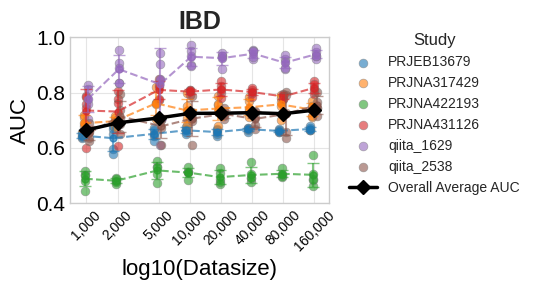

In [2]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import re # 用于解析 datasize

# --- 1. 加载数据 ---
file_path = data_root_path+ 'summary_ROC_results_datasize_IBD.csv'
try:
    df_full = pd.read_csv(file_path) # 先加载完整数据
    print("数据加载成功。")
except FileNotFoundError:
    print(f"错误：找不到文件 {file_path}")
    exit()

# --- 1.5 选择并过滤疾病 ---
if df_full.empty:
    print("错误：CSV 文件为空。")
    exit()

if 'disease' not in df_full.columns:
    print("错误：CSV 文件中缺少 'disease' 列。")
    exit()

diseases_in_file = df_full['disease'].unique()
if len(diseases_in_file) == 0:
    print("错误：未在 'disease' 列中找到任何疾病名称。")
    exit()

target_disease = 'IBD'
print(f"将绘制疾病 '{target_disease}' 的数据。")
df = df_full[df_full['disease'] == target_disease].copy()

if df.empty:
    print(f"错误：在文件中找到了疾病 '{target_disease}'，但筛选后没有数据。")
    exit()

# --- 2. 数据清洗与转换 ---
def parse_datasize(size_str):
    size_str = str(size_str).lower().strip()
    multiplier = 1
    if 'k' in size_str:
        multiplier = 1000
        size_str = size_str.replace('k', '')
    elif 'w' in size_str:
        multiplier = 10000
        size_str = size_str.replace('w', '')
    try:
        num_part = re.findall(r"[-+]?\d*\.?\d+", size_str)
        if num_part:
            return float(num_part[0]) * multiplier
        else:
            return np.nan
    except ValueError:
        return np.nan

df['datasize_numeric'] = df['datasize'].apply(parse_datasize)
df['auc'] = pd.to_numeric(df['auc'], errors='coerce')
df.dropna(subset=['datasize_numeric', 'auc'], inplace=True)

# --- 新增：移除 datasize_numeric 为 120000 (即 '12w') 的数据 ---
datasize_to_remove = 120000
df = df[df['datasize_numeric'] != datasize_to_remove].copy()
# -------------------------------------------------------------

if df.empty:
    print(f"错误：疾病 '{target_disease}' 的数据在处理和移除 '12w' 数据后为空。") # 更新了错误信息
    exit()

df.sort_values('datasize_numeric', inplace=True)

# --- MODIFICATION HERE: Sort unique_studies ---
unique_studies = sorted(df['test_study'].unique()) # Sort the study names
# --- END MODIFICATION ---

unique_datasizes = sorted(df['datasize_numeric'].unique()) # unique_datasizes 将不再包含 120000

# --- 3. 计算统计数据 --- (基于过滤后的df)
grouped_stats = df.groupby(['datasize_numeric', 'test_study'])['auc'].agg(['mean', 'std']).reset_index()
overall_mean_auc = df.groupby('datasize_numeric')['auc'].mean().reset_index()

# --- 4. 绘图 ---
disease_name = target_disease
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(6.5, 3))

def get_tab10_colors(n): # Renamed from get_set3_colors as it uses 'tab10'
    """Generates colors from the tab10 (Tableau10) colormap, cycling if necessary."""
    cmap = plt.cm.get_cmap('tab10')
    num_colors_in_map = cmap.N
    if n <= 0: return []
    return [cmap(i % num_colors_in_map) for i in range(n)]
palette = get_tab10_colors(len(unique_studies))

color_map = dict(zip(unique_studies, palette)) # This will now use sorted unique_studies
offset_scale = 0.03

for i, study in enumerate(unique_studies): # Iteration will be based on sorted studies
    study_data_grouped = grouped_stats[grouped_stats['test_study'] == study]
    study_data_raw = df[df['test_study'] == study] # 使用过滤后的 df
    color = color_map[study]
    current_offset_factor = (i - len(unique_studies) / 2) * offset_scale
    x_data_grouped_offset = study_data_grouped['datasize_numeric'] * (1 + current_offset_factor)
    # x_data_raw_offset = study_data_raw['datasize_numeric'] * (1 + current_offset_factor) #  这行在原代码中未使用，保持注释

    plt.errorbar(x_data_grouped_offset, study_data_grouped['mean'],
                 yerr=study_data_grouped['std'].fillna(0),
                 fmt='none',
                 capsize=4,
                 ecolor=color,
                 label='_nolegend_',
                 alpha=0.6,
                 elinewidth=1.5)

    plt.plot(x_data_grouped_offset, study_data_grouped['mean'],
             linestyle='--',
             marker='o',
             markersize=5,
             color=color,
             label='_nolegend_',
             alpha=0.7)

for i, study in enumerate(unique_studies): # Iteration will be based on sorted studies
    subset = df[df['test_study'] == study] # 使用过滤后的 df
    color = color_map[study]
    current_offset_factor = (i - len(unique_studies) / 2) * offset_scale
    x_data_subset_offset = subset['datasize_numeric'] * (1 + current_offset_factor)

    plt.scatter(x_data_subset_offset, subset['auc'],
                color=color,
                label=study, # Labels in legend will now be sorted
                s=40,
                alpha=0.6,
                edgecolors='grey',
                linewidth=0.5)

plt.plot(overall_mean_auc['datasize_numeric'], overall_mean_auc['auc'], # overall_mean_auc 也基于过滤后的 df
         linestyle='-',
         marker='D',
         color='black',
         linewidth=2.5,
         markersize=7,
         label='Overall Average AUC',
         zorder=5)

# --- 5. 设置图形属性 ---
plt.xlabel("log10(Datasize)", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.title(f"{disease_name}", fontsize=18, fontweight='bold')
plt.xscale('log')

def format_datasize_labels(value, pos):
    num = int(round(float(value)))
    return f"{num:,}"

    # return int(value) # Original commented out lines, kept for reference if needed
    # if value >= 10000:
    #     if value % 10000 == 0:
    #         return f'{int(value/10000)}w'
    #     else:
    #         return f'{value/10000:.1f}w'.replace('.0w', 'w')
    # elif value >= 1000:
    #     if value % 1000 == 0:
    #         return f'{int(value/1000)}k'
    #     else:
    #         return f'{value/1000:.1f}k'.replace('.0k', 'k')
    # return str(int(value))

# unique_datasizes 现在已经不包含 120000，所以对应的 '12w' 刻度不会被创建
plt.xticks(ticks=unique_datasizes, labels=[format_datasize_labels(ds, None) for ds in unique_datasizes], rotation=45, )
ax = plt.gca()
ax.xaxis.set_minor_locator(mticker.NullLocator())

min_auc_val = df['auc'].min() if not df.empty else 0.5 # 处理df可能为空的情况
max_auc_val = df['auc'].max() if not df.empty else 0.8 # 处理df可能为空的情况, though not directly used for ylim in this version
plt.ylim(0.4, 1)

ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black', labelsize=10)
ax.tick_params(axis='y', colors='black', labelsize=15)

ax.grid(True, which="major", axis='y', ls="-", alpha=0.5)
ax.grid(True, which="major", axis='x', ls="-", alpha=0.5)
ax.grid(False, which="minor")

plt.legend(title='Study', bbox_to_anchor=(1.03, 1.1), loc="upper left", fontsize=10, title_fontsize=12)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# 保存图像，可以指定分辨率(dpi)和去除多余空白(bbox_inches='tight')
image_description = "AUC_Datasize_LogScale" # 约3-4个词的描述
filename = f"{disease_name}_{image_description}.png" # 例如 CRC_AUC_Datasize_LogScale.png
plt.savefig(figure_root_path+filename, dpi=300, bbox_inches='tight')
print(f"图表已保存为: {filename}")

plt.show()

数据加载成功。
将绘制疾病 'CRC' 的数据。


/tmp/ipykernel_145825/2379443979.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


图表已保存为: CRC_AUC_Datasize_LogScale.png


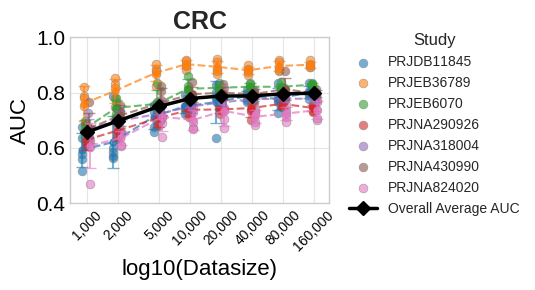

In [3]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import re # 用于解析 datasize

# --- 1. 加载数据 ---
file_path = data_root_path+'summary_ROC_results_datasize_CRC.csv'
try:
    df_full = pd.read_csv(file_path) # 先加载完整数据
    print("数据加载成功。")
except FileNotFoundError:
    print(f"错误：找不到文件 {file_path}")
    exit()

# --- 1.5 选择并过滤疾病 ---
if df_full.empty:
    print("错误：CSV 文件为空。")
    exit()

if 'disease' not in df_full.columns:
    print("错误：CSV 文件中缺少 'disease' 列。")
    exit()

diseases_in_file = df_full['disease'].unique()
if len(diseases_in_file) == 0:
    print("错误：未在 'disease' 列中找到任何疾病名称。")
    exit()

target_disease = 'CRC'
print(f"将绘制疾病 '{target_disease}' 的数据。")
df = df_full[df_full['disease'] == target_disease].copy()

if df.empty:
    print(f"错误：在文件中找到了疾病 '{target_disease}'，但筛选后没有数据。")
    exit()

# --- 2. 数据清洗与转换 ---
def parse_datasize(size_str):
    size_str = str(size_str).lower().strip()
    multiplier = 1
    if 'k' in size_str:
        multiplier = 1000
        size_str = size_str.replace('k', '')
    elif 'w' in size_str:
        multiplier = 10000
        size_str = size_str.replace('w', '')
    try:
        num_part = re.findall(r"[-+]?\d*\.?\d+", size_str)
        if num_part:
            return float(num_part[0]) * multiplier
        else:
            return np.nan
    except ValueError:
        return np.nan

df['datasize_numeric'] = df['datasize'].apply(parse_datasize)
df['auc'] = pd.to_numeric(df['auc'], errors='coerce')
df.dropna(subset=['datasize_numeric', 'auc'], inplace=True)

# --- 新增：移除 datasize_numeric 为 120000 (即 '12w') 的数据 ---
datasize_to_remove = 120000
df = df[df['datasize_numeric'] != datasize_to_remove].copy()
# -------------------------------------------------------------

if df.empty:
    print(f"错误：疾病 '{target_disease}' 的数据在处理和移除 '12w' 数据后为空。") # 更新了错误信息
    exit()

df.sort_values('datasize_numeric', inplace=True)

# --- MODIFICATION HERE: Sort unique_studies ---
unique_studies = sorted(df['test_study'].unique()) # Sort the study names
# --- END MODIFICATION ---

unique_datasizes = sorted(df['datasize_numeric'].unique()) # unique_datasizes 将不再包含 120000

# --- 3. 计算统计数据 --- (基于过滤后的df)
grouped_stats = df.groupby(['datasize_numeric', 'test_study'])['auc'].agg(['mean', 'std']).reset_index()
overall_mean_auc = df.groupby('datasize_numeric')['auc'].mean().reset_index()

# --- 4. 绘图 ---
disease_name = target_disease
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(6.5, 3))

def get_tab10_colors(n): # Renamed from get_set3_colors as it uses 'tab10'
    """Generates colors from the tab10 (Tableau10) colormap, cycling if necessary."""
    cmap = plt.cm.get_cmap('tab10')
    num_colors_in_map = cmap.N
    if n <= 0: return []
    return [cmap(i % num_colors_in_map) for i in range(n)]
palette = get_tab10_colors(len(unique_studies))

color_map = dict(zip(unique_studies, palette)) # This will now use sorted unique_studies
offset_scale = 0.03

for i, study in enumerate(unique_studies): # Iteration will be based on sorted studies
    study_data_grouped = grouped_stats[grouped_stats['test_study'] == study]
    study_data_raw = df[df['test_study'] == study] # 使用过滤后的 df
    color = color_map[study]
    current_offset_factor = (i - len(unique_studies) / 2) * offset_scale
    x_data_grouped_offset = study_data_grouped['datasize_numeric'] * (1 + current_offset_factor)
    # x_data_raw_offset = study_data_raw['datasize_numeric'] * (1 + current_offset_factor) #  这行在原代码中未使用，保持注释

    plt.errorbar(x_data_grouped_offset, study_data_grouped['mean'],
                 yerr=study_data_grouped['std'].fillna(0),
                 fmt='none',
                 capsize=4,
                 ecolor=color,
                 label='_nolegend_',
                 alpha=0.6,
                 elinewidth=1.5)

    plt.plot(x_data_grouped_offset, study_data_grouped['mean'],
             linestyle='--',
             marker='o',
             markersize=5,
             color=color,
             label='_nolegend_',
             alpha=0.7)

for i, study in enumerate(unique_studies): # Iteration will be based on sorted studies
    subset = df[df['test_study'] == study] # 使用过滤后的 df
    color = color_map[study]
    current_offset_factor = (i - len(unique_studies) / 2) * offset_scale
    x_data_subset_offset = subset['datasize_numeric'] * (1 + current_offset_factor)

    plt.scatter(x_data_subset_offset, subset['auc'],
                color=color,
                label=study, # Labels in legend will now be sorted
                s=40,
                alpha=0.6,
                edgecolors='grey',
                linewidth=0.5)

plt.plot(overall_mean_auc['datasize_numeric'], overall_mean_auc['auc'], # overall_mean_auc 也基于过滤后的 df
         linestyle='-',
         marker='D',
         color='black',
         linewidth=2.5,
         markersize=7,
         label='Overall Average AUC',
         zorder=5)

# --- 5. 设置图形属性 ---
plt.xlabel("log10(Datasize)", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.title(f"{disease_name}", fontsize=18, fontweight='bold')
plt.xscale('log')

def format_datasize_labels(value, pos):
    num = int(round(float(value)))
    return f"{num:,}"

    # return int(value) # Original commented out lines, kept for reference if needed
    # if value >= 10000:
    #     if value % 10000 == 0:
    #         return f'{int(value/10000)}w'
    #     else:
    #         return f'{value/10000:.1f}w'.replace('.0w', 'w')
    # elif value >= 1000:
    #     if value % 1000 == 0:
    #         return f'{int(value/1000)}k'
    #     else:
    #         return f'{value/1000:.1f}k'.replace('.0k', 'k')
    # return str(int(value))

# unique_datasizes 现在已经不包含 120000，所以对应的 '12w' 刻度不会被创建
plt.xticks(ticks=unique_datasizes, labels=[format_datasize_labels(ds, None) for ds in unique_datasizes], rotation=45, )
ax = plt.gca()
ax.xaxis.set_minor_locator(mticker.NullLocator())

min_auc_val = df['auc'].min() if not df.empty else 0.5 # 处理df可能为空的情况
max_auc_val = df['auc'].max() if not df.empty else 0.8 # 处理df可能为空的情况, though not directly used for ylim in this version
plt.ylim(0.4, 1)

ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black', labelsize=10)
ax.tick_params(axis='y', colors='black', labelsize=15)

ax.grid(True, which="major", axis='y', ls="-", alpha=0.5)
ax.grid(True, which="major", axis='x', ls="-", alpha=0.5)
ax.grid(False, which="minor")

plt.legend(title='Study', bbox_to_anchor=(1.03, 1.1), loc="upper left", fontsize=10, title_fontsize=12)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# 保存图像，可以指定分辨率(dpi)和去除多余空白(bbox_inches='tight')
image_description = "AUC_Datasize_LogScale" # 约3-4个词的描述
filename = f"{disease_name}_{image_description}.png" # 例如 CRC_AUC_Datasize_LogScale.png
plt.savefig(figure_root_path+filename, dpi=300, bbox_inches='tight')
print(f"图表已保存为: {filename}")

plt.show()